In [1]:
import random
import tensorflow as tf
import tensorflow.keras.backend as K

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pickle
import gower
import pydot

from pymoo.factory import get_decision_making
dm = get_decision_making("high-tradeoff")

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

<h5>Loading models</h5>

In [3]:
lgb_results = pickle.load(open('xmoai_results_lgb.pkl', 'rb'))
xgb_results = pickle.load(open('xmoai_results_xgb.pkl', 'rb'))
tf_results = pickle.load(open('xmoai_results_tf.pkl', 'rb'))
rf_results = pickle.load(open('xmoai_results_rf.pkl', 'rb'))

In [4]:
df_results = pd.DataFrame()
df_times = pd.DataFrame()
df_algorithms = pd.DataFrame(columns=['Index', 'CF', 'NSGA-II', 'NSGA-III', 'UNSGA-III', 'RNSGA-II'])

In [5]:
chosen_individuals = list(lgb_results.keys())

In [6]:
def get_df_results_xmoai(front, cfs, model):
    df_results = pd.DataFrame(front, columns=['Obj 1', 'Obj 2', 'Obj 3'])
    df_results['Model'] = model
    df_results['Index'] = index
    
    # get only the unique values
    index_to_drop = set(df_results.index) - set(pd.DataFrame(cfs).drop_duplicates().index)
    df_results = df_results.drop(index_to_drop)
    
    return df_results

def get_df_times(times, algorithm):
    df_times = pd.DataFrame(times, columns=['Times'])
    df_times['CF'] = algorithm
    
    return df_times

def get_df_algorithms(index, algorithms, algorithm):
    values = {'Index': index, 'CF': algorithm}
    for alg in ['NSGA-II', 'NSGA-III', 'UNSGA-III', 'RNSGA-II']:
        values[alg] = len(algorithms[algorithms==alg])
    
    return pd.DataFrame(list([values.values()]), columns=values.keys())

In [7]:
def get_outputs_xmoai(xmoai_results, index, model):
    # getting all the counterfactuals
    cfs = []
    for cfs_partial in xmoai_results[index][0]:
        [cfs.append(cf) for cf in cfs_partial]

    # getting the times
    times = xmoai_results[index][3]

    # getting the objectives
    front = []
    for front_partial in xmoai_results[index][1]:
        [front.append(f) for f in front_partial]
        
    # getting the algorithms
    alg = []
    for alg_partial in xmoai_results[index][2]:
        [alg.append(a[0]) for a in alg_partial]

    return get_df_results_xmoai(front, cfs, model), get_df_times(times, model), get_df_algorithms(index, np.array(alg), model)

<h5>xMOAI</h5>

In [8]:
for index in chosen_individuals:
    results, times, algorithms = get_outputs_xmoai(lgb_results, index, 'LGBM')
    df_results = pd.concat([df_results, results])
    df_times = pd.concat([df_times, times])
    df_algorithms = pd.concat([df_algorithms, algorithms], ignore_index=True)

In [9]:
for index in chosen_individuals:
    results, times, algorithms = get_outputs_xmoai(xgb_results, index, 'XGB')
    df_results = pd.concat([df_results, results])
    df_times = pd.concat([df_times, times])
    df_algorithms = pd.concat([df_algorithms, algorithms], ignore_index=True)

In [10]:
for index in chosen_individuals:
    results, times, algorithms = get_outputs_xmoai(tf_results, index, 'Tensorflow')
    df_results = pd.concat([df_results, results])
    df_times = pd.concat([df_times, times])
    df_algorithms = pd.concat([df_algorithms, algorithms], ignore_index=True)

In [11]:
for index in chosen_individuals:
    results, times, algorithms = get_outputs_xmoai(rf_results, index, 'scikit-learn')
    df_results = pd.concat([df_results, results])
    df_times = pd.concat([df_times, times])
    df_algorithms = pd.concat([df_algorithms, algorithms], ignore_index=True)

<ipython-input-6-9387113ec3c3>:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  values[alg] = len(algorithms[algorithms==alg])


In [12]:
# selecting only the non-dominated solutions
df_non_dominated = df_results.copy().reset_index(drop=True)

dominated_indexes = []
for index in chosen_individuals:
    for technique in df_non_dominated[df_non_dominated['Index']==index]['Model'].unique():
        df_test = df_non_dominated[(df_non_dominated['Index']==index) & (df_non_dominated['Model']==technique)]
        
        for index in df_test.index:
            solution = df_test.loc[index].values
            if np.sum(np.all(solution >= df_test.values, axis=1)) > 1:
                dominated_indexes.append(index)

df_non_dominated = df_non_dominated.drop(dominated_indexes)

In [13]:
markers = {'LGBM': 'o', 'XGB': 'D', 'Tensorflow': '^', 'scikit-learn': 'v'}
colors = {'LGBM': 'm', 'XGB': 'r', 'Tensorflow': 'b', 'scikit-learn': 'k'}

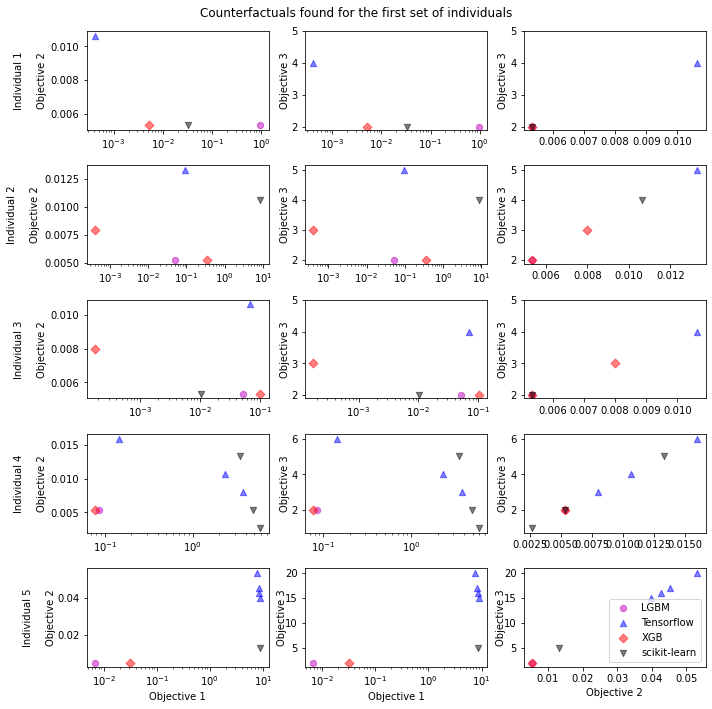

In [29]:
fig = plt.figure(figsize=(10,10))#, constrained_layout=True)
gs0 = gridspec.GridSpec(5, 1, figure=fig)

count = 1
for index in chosen_individuals[:5]:
    df_test = df_non_dominated[ (df_non_dominated['Index']==index)]
    #fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))
    
    gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[count-1])
    
    s = 40
    alpha = 0.5

    for technique in np.unique(df_test['Model'].values):
        df_current = df_test[df_test['Model']==technique]

        try:
            df_current = df_current.iloc[dm.do(df_current[['Obj 1', 'Obj 2', 'Obj 3']].values)]
        except:
            display(df_current.shape)
            
        label = technique
                
        ax1 = fig.add_subplot(gs00[:, 0])
        ax1.scatter(df_current['Obj 1'].values, df_current['Obj 2'].values,
                    alpha=alpha, s=s, marker=markers[technique], color=colors[technique], label=label)
        
        ax2 = fig.add_subplot(gs00[:, 1])
        ax2.scatter(df_current['Obj 1'].values, df_current['Obj 3'].values,
                    alpha=alpha, s=s, marker=markers[technique], color=colors[technique], label=label)

        ax3 = fig.add_subplot(gs00[:, 2])
        ax3.scatter(df_current['Obj 2'].values, df_current['Obj 3'].values,
                    alpha=alpha, s=s, marker=markers[technique], color=colors[technique], label=label)
        
        if count == 5:
            ax1.set_xlabel('Objective 1')
            ax2.set_xlabel('Objective 1')
            ax3.set_xlabel('Objective 2')

        ax1.set_xscale('log')
        ax2.set_xscale('log')
        #ax3.set_xscale('log')
        
        #ax1.set_yscale('log')
        #ax2.set_yscale('log')
        #ax3.set_yscale('log')
        
        if count <= 3:
            ax2.set_yticks([2, 3, 4, 5])
            ax3.set_yticks([2, 3, 4, 5])
            
        if count != 5:
            ax1.set_ylabel(f'Individual {count}\n\nObjective 2')
            ax2.set_ylabel('Objective 3', labelpad=2)
            ax3.set_ylabel('Objective 3', labelpad=2)
        else:
            ax1.set_ylabel(f'Individual {count}\n\nObjective 2', labelpad=1)
            ax2.set_ylabel('Objective 3', labelpad=-2)
            ax3.set_ylabel('Objective 3', labelpad=-2)
            
        if count == 5:
            plt.legend(loc='lower right')
            
    count += 1
    
fig.suptitle(f'Counterfactuals found for the first set of individuals')
plt.tight_layout()
plt.savefig('set1.jpg', bbox_inches='tight')

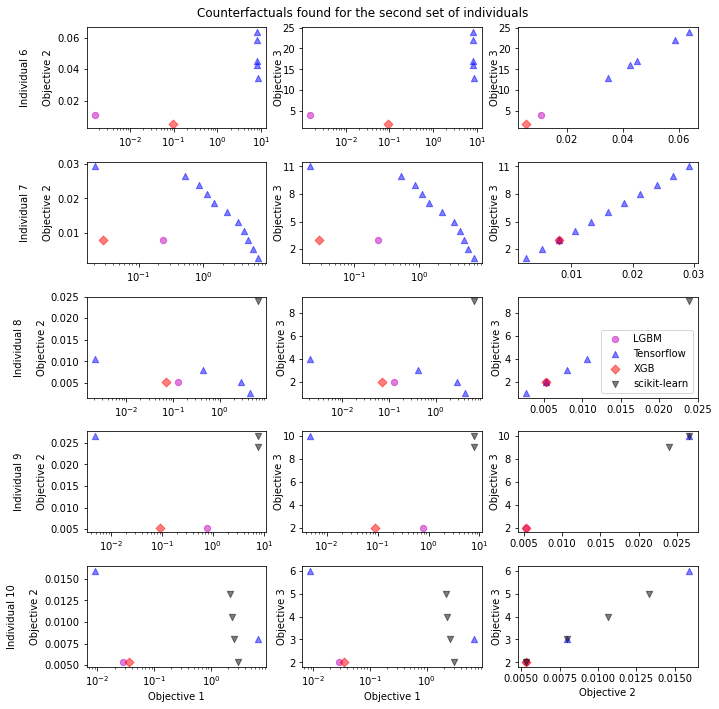

In [27]:
fig = plt.figure(figsize=(10,10))#, constrained_layout=True)
gs0 = gridspec.GridSpec(5, 1, figure=fig)

count = 1
for index in chosen_individuals[5:]:
    df_test = df_non_dominated[ (df_non_dominated['Index']==index)]
    #fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))
    
    gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[count-6])
    
    s = 40
    alpha = 0.5

    for technique in np.unique(df_test['Model'].values):
        df_current = df_test[df_test['Model']==technique]

        try:
            df_current = df_current.iloc[dm.do(df_current[['Obj 1', 'Obj 2', 'Obj 3']].values)]
        except:
            display(df_current.shape)
        
        label = technique
                
        ax1 = fig.add_subplot(gs00[:, 0])
        ax1.scatter(df_current['Obj 1'].values, df_current['Obj 2'].values,
                    alpha=alpha, s=s, marker=markers[technique], color=colors[technique], label=label)
        
        ax2 = fig.add_subplot(gs00[:, 1])
        ax2.scatter(df_current['Obj 1'].values, df_current['Obj 3'].values,
                    alpha=alpha, s=s, marker=markers[technique], color=colors[technique], label=label)

        ax3 = fig.add_subplot(gs00[:, 2])
        ax3.scatter(df_current['Obj 2'].values, df_current['Obj 3'].values,
                    alpha=alpha, s=s, marker=markers[technique], color=colors[technique], label=label)
        
        if count == 5:
            ax1.set_xlabel('Objective 1')
            ax2.set_xlabel('Objective 1')
            ax3.set_xlabel('Objective 2')

        ax1.set_xscale('log')
        ax2.set_xscale('log')
        #ax3.set_xscale('log')
        
        #ax1.set_yscale('log')
        #ax2.set_yscale('log')
        #ax3.set_yscale('log')
        
        if count == 2:
            ax2.set_yticks([2, 5, 8, 11])
            ax3.set_yticks([2, 5, 8, 11])
            
        if count <=2 or count == 4:
            ax2.set_ylabel('Objective 3', labelpad=-2)
            ax3.set_ylabel('Objective 3', labelpad=-2)
        else:
            ax2.set_ylabel('Objective 3', labelpad=2)
            ax3.set_ylabel('Objective 3', labelpad=2)
            
        ax1.set_ylabel(f'Individual {count+5}\n\nObjective 2')
        
        if count == 3:
            plt.legend(loc='lower right')
        
    count += 1
   
fig.suptitle(f'Counterfactuals found for the second set of individuals')
plt.tight_layout()
plt.savefig('set2.jpg', bbox_inches='tight')

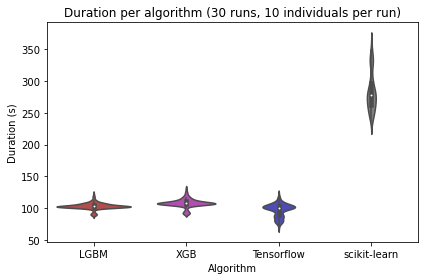

In [34]:
plt.figure(figsize=(6,4))
df_violin = df_times.copy()
ax = sns.violinplot(x='CF', y='Times', data=df_violin, palette=['red', 'magenta', 'blue', 'gray'], saturation=0.4)
plt.title('Duration per algorithm (30 runs, 10 individuals per run)')
ax.set_xlabel('Algorithm')
ax.set_ylabel('Duration (s)')
plt.tight_layout()
plt.savefig('times_reg.jpg')

In [255]:
model = tf.keras.models.load_model('model_reg')

In [256]:
#tf.keras.utils.plot_model(model, to_file='model_reg_out.png', show_shapes=False, dpi=72, show_layer_names=False, rankdir='TB')

In [31]:
df_counts = df_non_dominated.groupby(['Index', 'Model'], as_index=False).count().drop(['Obj 2', 'Obj 3'], axis=1)
df_counts = pd.DataFrame(pd.pivot_table(df_counts, columns=['Model'], index=['Index'], values=['Obj 1']).fillna(0).to_records())

for col in df_counts.columns:
    df_counts[col] = df_counts[col].astype(int)

df_counts.to_csv('reg_results.csv')
df_counts

,Index,"('Obj 1', 'LGBM')","('Obj 1', 'Tensorflow')","('Obj 1', 'XGB')","('Obj 1', 'scikit-learn')"
0,3374,7,78,63,158
1,3415,7,75,66,46
2,3422,7,88,76,125
3,3455,7,107,90,67
4,3459,10,133,60,17
5,3544,9,110,69,0
6,3580,7,227,81,0
7,3590,9,95,83,33
8,3640,8,92,70,33
9,3815,5,80,69,184


In [32]:
df_algorithms_plot = df_algorithms.melt(id_vars=['Index', 'CF'])
df_algorithms_plot['value'] = df_algorithms_plot['value'].astype('float64')

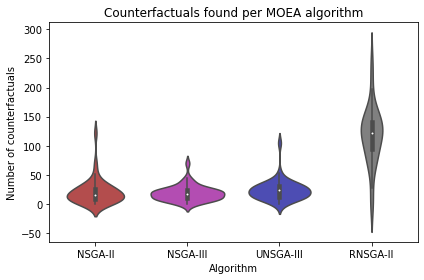

In [33]:
plt.figure(figsize=(6,4))
df_violin = df_times.copy()
ax = sns.violinplot(data=df_algorithms_plot, x='variable', y='value', palette=['red', 'magenta', 'blue', 'gray'], saturation=0.4)
plt.title('Counterfactuals found per MOEA algorithm')
ax.set_xlabel('Algorithm')
ax.set_ylabel('Number of counterfactuals')
plt.tight_layout()
plt.savefig('cfs_moo.jpg')